# Example reflectance calculation

This notebook is a simple demonstration of using radiance hyperspectral UAV images and measurements of downwelling irradiance to calculate reflectance images. 

The example shown here is based on data from the [Massimal dataset](https://doi.org/10.11582/2025.00041), specifically the ZIP file [massimal_bodo_juvika_202104181131-transects-15m_hsi.zip](https://ns9999k.webs.sigma2.no/10.11582_2025.00041/bodo/juvika/aerial/hsi/20210418/massimal_bodo_juvika_202104181131-transects-15m_hsi/processed/massimal_bodo_juvika_202104181131-transects-15m_hsi.zip). The notebook also uses the [MassiPipe](https://github.com/mh-skjelvareid/massipipe) data processing pipeline developed as part of the same research project that collected the data. 

To run this code on your own machine, install MassiPipe, download the data ZIP file, and update the paths in the third cell below. 

In [1]:
# Imports
from pathlib import Path
from zipfile import ZipFile
from rich import print
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.patches import Polygon

import massipipe


In [2]:
# Parameters (see example image further down)
example_image_number = 2 
gray_panel_vertices = ((222,764),(246,770),(255,780),(256,803),(248,808),(223,804),(211,795),(212,771))

In [3]:
# Paths (edit to correspond to local file placement)
hyspec_zip_path = Path("/home/mha114/data/seabee-minio/bodo/juvika/aerial/hsi/20210418/massimal_bodo_juvika_202104181131-transects-15m_hsi/processed/massimal_bodo_juvika_202104181131-transects-15m_hsi.zip")
data_root_dir = Path("/home/mha114/data/examples/reflectance_calculation_1")
hyspec_dataset_dir = data_root_dir / hyspec_zip_path.stem
gray_card_mask_path = Path("masks/gray_panel_mask.png")
light_brown_algae_mask_path = Path("masks/light_brown_algae.png")
sand_mask_path = Path("masks/sand.png")

notebook_dir = Path("/home/mha114/code/github/massimal-dataset/notebooks/hsi_reflectance") 
figures_dir = notebook_dir / "exported_figures"
figures_dir.mkdir(exist_ok=True)

In [4]:
# Extract hyperspectral data from zip file (could take a few minutes)
hyspec_dataset_dir.mkdir(parents=True,exist_ok=True)

if not any(hyspec_dataset_dir.iterdir()): # If first time (folder empty)
    with ZipFile(hyspec_zip_path,"r") as hyspec_zip_file:
        hyspec_zip_file.extractall(hyspec_dataset_dir) # Unzip

In [5]:
# Create pipeline
pipeline = massipipe.Pipeline(hyspec_dataset_dir)

17:09:47 INFO: ----------------------------------------------------------------
17:09:47 INFO: File logging for massimal_bodo_juvika_202104181131-transects-15m_hsi initialized.
17:09:47 INFO: No raw files found, but radiance directory 1a_radiance found - processing based on radiance data.


Note that the MassiPipe pipeline can be used either with raw data or radiance (processed) data as the starting point. In this case, the ZIP file only contains radiance data. 

In [6]:
# Print pipeline configuration (read from YAML file in dataset)
print(pipeline.config)

MassipipeOptions(
    general=MpGeneral(rgb_wl=(640.0, 550.0, 460.0)),
    quicklook=MpQuickLook(create=True, overwrite=False, percentiles=None),
    imu_data=MpImuData(create=True, overwrite=False),
    geotransform=MpGeoTransform(
        create=True,
        overwrite=True,
        camera_opening_angle_deg=36.5,
        pitch_offset_deg=4.0,
        roll_offset_deg=0.0,
        altitude_offset_m=9.0,
        utm_x_offset_m=1.0,
        utm_y_offset_m=0.0,
        assume_square_pixels=False
    ),
    radiance=MpRadiance(
        create=True,
        overwrite=False,
        set_saturated_pixels_to_zero=True,
        add_envi_mapinfo_to_header=True,
        add_irradiance_to_header=True
    ),
    radiance_rgb=MpRadianceRgb(create=True, overwrite=False),
    radiance_gc=MpRadianceGc(
        create=False,
        overwrite=False,
        smooth_spectra=True,
        subtract_dark_spec=False,
        set_negative_values_to_zero=False,
        reference_image_numbers=[3],
        reference_image_ranges=[(450, 850, 550, 900)]
    ),
    radiance_gc_rgb=MpRadianceGcRgb(create=False, overwrite=False),
    irradiance=MpIrradiance(create=True, overwrite=False),
    reflectance=MpReflectance(
        create=False,
        overwrite=False,
        wl_min=400,
        wl_max=930,
        conv_irrad_with_gauss=True,
        fwhm_irrad_smooth=3.5,
        smooth_spectra=False,
        refl_from_mean_irrad=False
    ),
    reflectance_gc=MpReflectanceGc(create=False, overwrite=False, smooth_spectra=True, method='from_rad_gc'),
    reflectance_gc_rgb=MpReflectanceGcRgb(create=False, overwrite=False),
    mosaic=MpMosaic(
        overview_factors=[2, 4, 8, 16, 32],
        visualization_mosaic='radiance',
        radiance_rgb=MpMosaicRadiance(create=True, overwrite=False),
        radiance_gc_rgb=MpMosaicRadianceGc(create=False, overwrite=False),
        reflectance_gc_rgb=MpMosaicReflectanceGc(create=False, overwrite=False)
    )
)

Note that conversion to reflectance can also be done by adjusting the configuration parameters (reflectance.create = True) and using pipeline.run().

# Note: Wavelength calibration needed
The dataset used here is one of the earliest datasets that were recorded. When publishing the full MASSIMAL dataset, there were details about this (Juvika) dataset that had to be manually handled. For this reason, the wavelength calibration for irradiance spectra that is default in the pipeline was NOT performed, and it therefore needs to be performed manually here. We apologize for the confusion this causes. 

In [7]:
pipeline.calibrate_irradiance_wavelengths()

17:09:47 INFO: ---- IRRADIANCE WAVELENGTH CALIBRATION ----
17:09:47 INFO: Calibrating wavelengths for massimal_bodo_juvika_202104181131-transects-15m_hsi_000_irradiance.spec.hdr
17:09:47 INFO: Calibrating wavelengths for massimal_bodo_juvika_202104181131-transects-15m_hsi_001_irradiance.spec.hdr
17:09:47 INFO: Calibrating wavelengths for massimal_bodo_juvika_202104181131-transects-15m_hsi_002_irradiance.spec.hdr
17:09:47 INFO: Calibrating wavelengths for massimal_bodo_juvika_202104181131-transects-15m_hsi_003_irradiance.spec.hdr
17:09:47 INFO: Calibrating wavelengths for massimal_bodo_juvika_202104181131-transects-15m_hsi_004_irradiance.spec.hdr
17:09:47 INFO: Calibrating wavelengths for massimal_bodo_juvika_202104181131-transects-15m_hsi_005_irradiance.spec.hdr


In [8]:
pipeline.add_irradiance_to_radiance_header()

17:09:47 INFO: ---- WRITING IRRADIANCE TO RADIANCE HEADER ----
17:09:47 INFO: Writing irradiance to radiance header massimal_bodo_juvika_202104181131-transects-15m_hsi_000_radiance.bip.hdr.
17:09:47 INFO: Writing irradiance to radiance header massimal_bodo_juvika_202104181131-transects-15m_hsi_001_radiance.bip.hdr.
17:09:47 INFO: Writing irradiance to radiance header massimal_bodo_juvika_202104181131-transects-15m_hsi_002_radiance.bip.hdr.
17:09:47 INFO: Writing irradiance to radiance header massimal_bodo_juvika_202104181131-transects-15m_hsi_003_radiance.bip.hdr.
17:09:47 INFO: Writing irradiance to radiance header massimal_bodo_juvika_202104181131-transects-15m_hsi_004_radiance.bip.hdr.
17:09:47 INFO: Writing irradiance to radiance header massimal_bodo_juvika_202104181131-transects-15m_hsi_005_radiance.bip.hdr.


The calibrate_irradiance_wavelengths() function uses Fraunhofer lines to calibrate the irradiance spectrum files. The add_irradiance_to_radiance_header() reads these files, smooths them to make the spectral resolution more similar to that of the hyperspectral camera, resamples the spectrum to the wavelenghts of the camera, and writes the spectrum to the header of the radiance images.  

In [9]:
# Read example hyperspectral image
image_rad = massipipe.utils.read_envi(pipeline.rad_im_paths[example_image_number])
image_rad, wl_rad, metadata_rad = image_rad # Unpack multiple return args

In [10]:
# Create RGB version view of hyperspectral image
image_rad_rgb,rgb_wl = massipipe.utils.rgb_subset_from_hsi(image_rad,wl_rad)
image_rad_rgb = massipipe.utils.percentile_stretch_image(image_rad_rgb)

In [12]:
# Read gray card mask 
mask = imread(gray_card_mask_path).astype(np.bool)
mask = mask & ~ np.all(image_rad_rgb==0,axis=2) # Exclude all-zero (invalid) pixels
image_rad_rgb_masked = image_rad_rgb*np.atleast_3d(mask)

The mask is a PNG file that has been specially prepared for this example. It was created with ImageJ / [Fiji](https://imagej.net/software/fiji/). 

The hyperspectral image contains a number of pixels that are zero across all bands. These are pixels that were saturated in the original image. We manually exclude these pixels from the mask. 

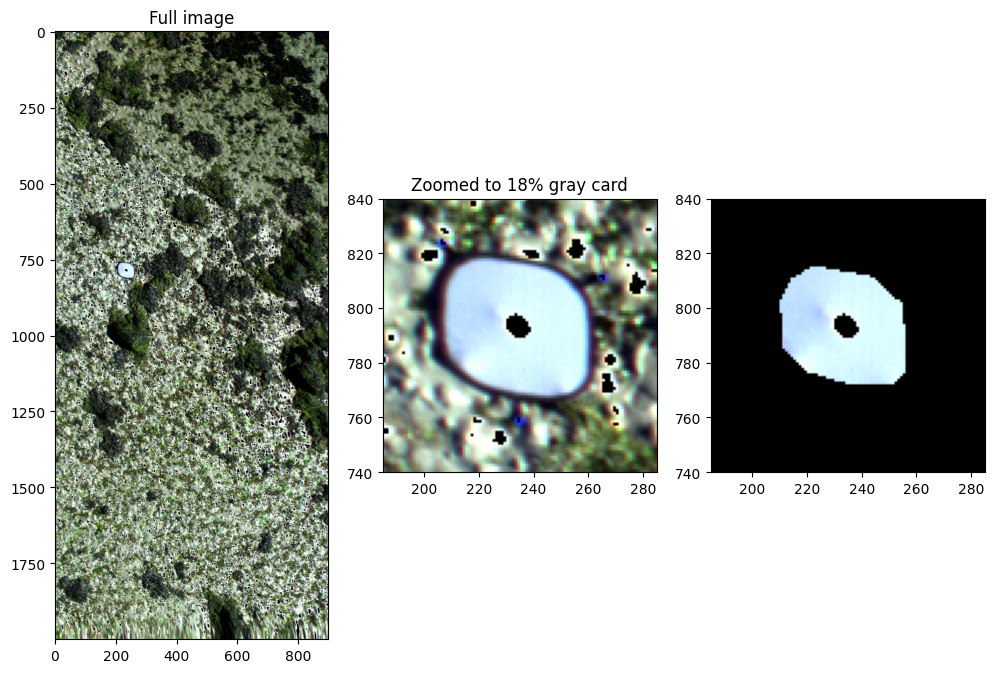

In [13]:
fig,axs = plt.subplots(ncols=3,figsize=(12,8))

ref_win = (185,285,740,840)
x_win_min,x_win_max,y_win_min,y_win_max = ref_win

axs[0].imshow(image_rad_rgb)
axs[1].imshow(image_rad_rgb[y_win_min:y_win_max,x_win_min:x_win_max,:],extent=ref_win)
axs[2].imshow(image_rad_rgb_masked[y_win_min:y_win_max,x_win_min:x_win_max,:],extent=ref_win)
axs[0].set_title("Full image")
axs[1].set_title("Zoomed to 18% gray card")
plt.show()

The leftmost image figure shows the full image. The gray card was placed on sand (above water) among clusters of macroalgae. All the black spots in the image correspond to invalid pixels (saturated in the original image).

The gray panel shown above is a foldable "gray card" with 18% reflectance, manufactured by Caruba. The card is approxuimately 50x50 cm.

<img src="illustration_images/caruba_gray_card.jpg" width="30%">

In [14]:
# Calculate mean spectrum for reflectance panel (within mask)
gray_panel_spec = image_rad[mask]
gray_panel_mean_spec = np.mean(gray_panel_spec,axis=0)
gray_panel_percentiles = np.percentile(gray_panel_spec,(5,95),axis=0)

In [15]:
# Read downwelling irradiance spectrum (original)
dw_spec,wl_spec,metadata_spec = massipipe.utils.read_envi(pipeline.irrad_spec_paths[example_image_number])
dw_spec = np.squeeze(dw_spec) # Reduce from 3D to 1D array

In [16]:
# Read downwelling irradiance spectrum, from radiance header (resampled)
dw_spec_resamp = massipipe.utils.header_string_to_array(metadata_rad["solar irradiance"])

In [17]:
# Calculate mean reflectance of panel by dividing radiance by reflectance
gray_panel_refl_mean = np.pi*(gray_panel_mean_spec/massipipe.utils.irrad_si_um_to_uflicklike(dw_spec_resamp))

Reflectance is calculated as $\rho = \pi * \frac{L}{E}$, with $L$ denoting radiance and $E$ denoting downwelling irradiance. The function irrad_si_um_to_uflicklike() is used to convert the irradiance spectrum to units that match the microflick unit of the mean radiance spectrum. 

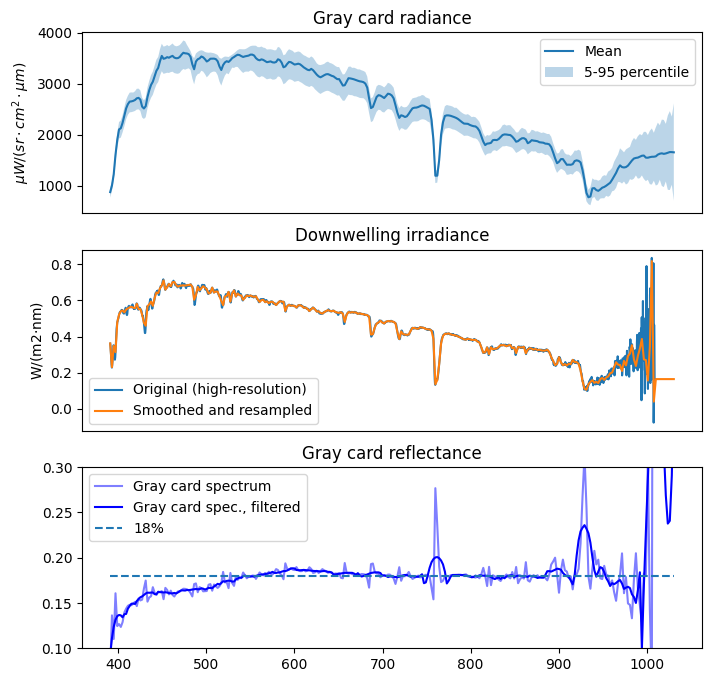

In [18]:
# Plot gray panel spectrum and compare with downwelling spectrum
fig,axs = plt.subplots(nrows=3,figsize=(8,8))
axs[0].plot(wl_rad,gray_panel_mean_spec,label="Mean")
axs[0].fill_between(wl_rad, gray_panel_percentiles[0],gray_panel_percentiles[1],alpha=0.3,label="5-95 percentile")
axs[0].set_title("Gray card radiance")
axs[0].set_ylabel("$\mu W/(sr\cdot cm^2 \cdot \mu m)$")
axs[0].set_xticks([])
axs[0].legend()

dw_spec_ind = (wl_spec >= wl_rad[0]) & (wl_spec <= wl_rad[-1]) 
axs[1].plot(wl_spec[dw_spec_ind],dw_spec[dw_spec_ind],label="Original (high-resolution)")
axs[1].plot(wl_rad,dw_spec_resamp/1000,label="Smoothed and resampled")
axs[1].set_title("Downwelling irradiance")
axs[1].set_xticks([])
axs[1].set_ylabel("W/(m2$\cdot$nm)")
axs[1].legend()

axs[2].plot(wl_rad,gray_panel_refl_mean,label="Gray card spectrum",color='b',alpha=0.5)
axs[2].plot(wl_rad,massipipe.utils.savitzky_golay_filter(gray_panel_refl_mean,axis=0),label="Gray card spec., filtered",color="b")

axs[2].plot(wl_rad,0.18*np.ones_like(wl_rad),'--',label="18%")
axs[2].set_title("Gray card reflectance")
axs[2].set_ylim([0.1,0.3])
axs[2].legend()

plt.show()

## Upper plot: Radiance
The uppermost plot shows the mean radiance values for the gray card, with the 5th and 95th percentiles indicating the range of values. Note that the width of the percentile band increases above 950 where the signal-to-noise ratio is generally very low. The radiance unit used in the plot are "microflicks" ($\mu W/(sr\cdot cm^2 \cdot \mu m)$), the native unit used for the hyperspectral images. 

## Middle plot: Downwelling irradiance
The middle plot shows two versions of the downwelling irradiance measured using a spectrometer with a cosine collector. The high-resolution version is the original (calibrated) spectrum, and the resampled version is the version read from the radiance header file. The two versions are very similar, except for the upper NIR region, which is again very noisy. Note that the depth of some of the absorption lines ("dips") is slightly smaller for the smoothed spectrum. The irradiance unit used in the plot is $W/(m^2\cdot nm)$, the native unit used for the irradiance spectrum files. The resampled spectrum is written to the radiance header files in units of $W/(m^2\cdot\mu m)$, and thus has to be scaled before plotting.  

## Lower plot
The lower plot shows two versions of the reflectance spectrum; the original calculated from radiance and irradiance, and a version smoothed with as Savitzsky-Golay filter. The dotted line indicates the 18% reflectance that is expected for the gray card. The reflectance values are generally close to 18%, but in the 400-550 nm range the values are slightly lower. There are unfortunately no detailed laboratory measurements available for the gray card. The offset from 18% could possibly be a property of the gray card itself, and/or be caused by systematic offsets in the hyperspectral camera and irradiance spectrometer. However, the offset is not seen as major problem for data quality in this context.  

In the wavelength ranges close to the Fraunhofer lines (the spectral dips), reflectance values have small spikes. The most pronounced of these is around 760 nm, the Fraunhofer line "A" caused by oxygen in the atmosphere. The smaller spikes are smoothed out by the Savitzsky-Golay filter, but the spike at line A is not smoothed out, and it is prabably better to exclude reflectance values in a narrow window around 760 nm. The spikes are most probably caused by small mismatches in wavelength and/or spectral values, which are magnified when one spectrum is divided by the other. Above 900 nm, low signal-to-noise levels causes the reflectance values to "blow up".  

The following example spectrum from the [Wikipedia article on Fraunhofer lines](https://en.wikipedia.org/wiki/Fraunhofer_lines) is interesting for comparison with the spectra above:
<div style="display:inline-block; background-color:white; padding:10px;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Solar_spectral_irradiance.svg/1024px-Solar_spectral_irradiance.svg.png" alt="image" />
</div>


In [19]:
# Run pipeline to convert radiance image to reflectance
pipeline.convert_radiance_images_to_reflectance()

17:10:27 INFO: ---- REFLECTANCE CONVERSION ----
17:10:27 INFO: Image massimal_bodo_juvika_202104181131-transects-15m_hsi_000_reflectance.bip.hdr exists - skipping.
17:10:27 INFO: Image massimal_bodo_juvika_202104181131-transects-15m_hsi_001_reflectance.bip.hdr exists - skipping.
17:10:27 INFO: Image massimal_bodo_juvika_202104181131-transects-15m_hsi_002_reflectance.bip.hdr exists - skipping.
17:10:27 INFO: Image massimal_bodo_juvika_202104181131-transects-15m_hsi_003_reflectance.bip.hdr exists - skipping.
17:10:27 INFO: Image massimal_bodo_juvika_202104181131-transects-15m_hsi_004_reflectance.bip.hdr exists - skipping.
17:10:27 INFO: Image massimal_bodo_juvika_202104181131-transects-15m_hsi_005_reflectance.bip.hdr exists - skipping.


In [20]:
# Read reflectance hyperspectral image
image_refl = massipipe.utils.read_envi(pipeline.refl_im_paths[example_image_number])
image_refl, wl_refl, metadata_refl = image_refl # Unpack multiple return args

image_refl_rgb,_ = massipipe.utils.rgb_subset_from_hsi(image_refl,wl_refl)

In [21]:
# Read masks for sand and brown algae 
sand_mask = imread(sand_mask_path).astype(np.bool)
sand_mask = sand_mask & ~ np.all(image_rad_rgb==0,axis=2) # Exclude all-zero (invalid) pixels

brown_algae_mask = imread(light_brown_algae_mask_path).astype(np.bool)
brown_algae_mask = brown_algae_mask & ~ np.all(image_rad_rgb==0,axis=2) # Exclude all-zero (invalid) pixels

sand_and_algae_mask = np.atleast_3d(sand_mask | brown_algae_mask).astype(np.float32)

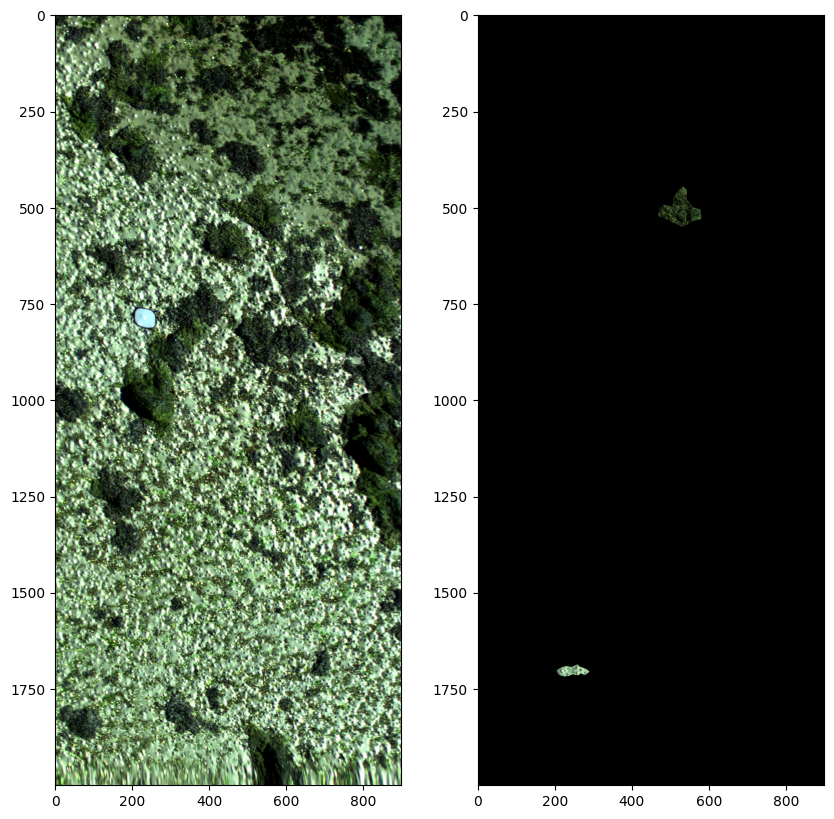

In [22]:
# Show reflectance image and masks
fig,axs = plt.subplots(ncols=2,figsize=(10,10))
axs[0].imshow(massipipe.utils.percentile_stretch_image(image_refl_rgb))
axs[1].imshow(massipipe.utils.percentile_stretch_image(image_refl_rgb)*sand_and_algae_mask.astype(np.uint8))
plt.show()

Note that the RGB version of the reflectance image looks identical to the RGB version of the radiance image. This is because both images are percentile stretched. The masked version of the image shows the brown algae and sand areas used to extract example spectra. 

In [23]:
# Calculate mean spectra for sand and brown algae
sand_spec_mean = np.mean(image_refl[sand_mask],axis=0)
brown_algae_spec_mean = np.mean(image_refl[brown_algae_mask],axis=0)

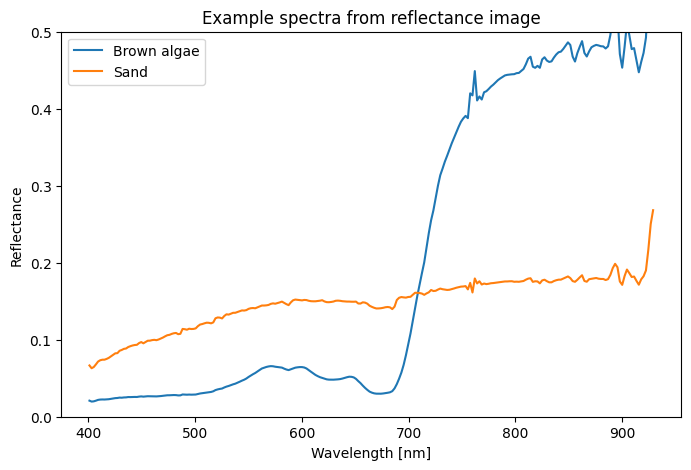

In [24]:
# Plot mean spectra
fig,ax = plt.subplots(nrows=1,figsize=(8,5))
ax.plot(wl_refl,brown_algae_spec_mean,label='Brown algae')
ax.plot(wl_refl,sand_spec_mean,label='Sand')
ax.set_title("Example spectra from reflectance image")
ax.set_ylim([0,0.5])
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Reflectance")
ax.legend()
plt.show()